# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences test or speech)
Another common term for NLP problems is sequence to sequence problems (seq2seq)

## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
from helper_functions import *

## Get a text dataset

The dataset we're going to be using is Kaggle's untroduction to NLP dataset.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data('nlp_getting_started.zip')

The above happened because I switched to local runtime

## Visualize a text dataset

Its very redundant to watch him tbh. I already know a lot of this. The more I watch the course the more I realize that I know enough

In [1]:
import pandas as pd
train_df = pd.read_csv('train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [3]:
# Shuffle training dataframe
train_df_shuffle = train_df.sample(frac=1, random_state=42)
train_df_shuffle.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [4]:
# How many example of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [5]:
# How many total samples 
len(train_df), len(test_df)

(7613, 3263)

In [6]:
# Let's visualize a random training example
import random
random_index = random.randint(0, len(train_df) - 5)
for row in train_df_shuffle[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f'Target: {target}' '(real disaster)' if target > 0 else '(not real disaster')
  print(f'Text:\n {text}\n')
  print('---\n')

Target: 1(real disaster)
Text:
 13 security personnel killed in Iraq suicide bombing | http://t.co/IbAZRHlSUr http://t.co/B6wWq2nYQI

---

(not real disaster
Text:
 Panicking because maybe my bff left me at China Bar or maybe tindering on the toilet for 20mins

---

Target: 1(real disaster)
Text:
 @ameenshaikh3 by ur. logic if bridge didnt collapse then second train engine should cross bridge then  @sanjaynirupam @sureshprabhu

---

(not real disaster
Text:
 lmao fuckboy changed his @ for damage control
@Pseudojuuzo

---

Target: 1(real disaster)
Text:
 #Battlefield 1942 forgotten hope secret weapons

---



### Split data into training and validation sets


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffle['text'].to_numpy(),
                                                                            train_df_shuffle['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [9]:
# Check
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [10]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenazation - direct mapping of token (a token could be a vword or a character) to a number
* Embedding - create a matrix of a feature vector for each token (size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [11]:
import tensorflow as tf
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import TextVectorization

In [12]:
# Use the default parameters
text_vectorizer = TextVectorization(max_tokens=1000, #How many words in the vocab
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None,
                                    output_mode='int',
                                    output_sequence_length=None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=True
                                    ) 

The TextVectorization deafault max_tokens means that it has no limit to the words. It tries to figure out how many words you have to use automatically add <00V>

In [13]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [14]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/ len(train_sentences)) 

15

In [15]:
# Setup text vectorization variables 
max_vocab_length = 10000  # max number of words to have in our vocab
max_length = 15           # max length our sequences will be (e.g how many words from a tweet does a model see?)
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length,
                                    split='whitespace')

In [16]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [17]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [18]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
    \n\nVectorized version:')
text_vectorizer([random_sentence])

Original text:
 Fire Call: BRANT AV / DRUMMOND RD for Fire - *Structure - Single. Units: CAR 6 On Call Truck http://t.co/euDwNFyUeM    

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  42,  425,    1, 3169,    1,  765,   10,   42, 2277, 1366, 1574,
         127,  560,   11,  425]], dtype=int64)>

In [19]:
# Get the unique words in the vocub
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'Top 5 words: {top_5_words}')
print(f'Bottom 5 words: {bottom_5_words}')

Number of words in vocab: 10000
Top 5 words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding Layer

To make our embedding, we are going to use tensorflows embedding method: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* input_dim = the size of our vocab
* output_dim = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* iinput_length = length of the sequences being passed to the embedding layer



In [20]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length)
embedding

In [21]:
# Get a random sentence from the training set 
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
\n\nEmbedded version:')

# Embed the random sentence (turns it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 A good piece on Israeli incitement and Jewish terrorism by Beinart: http://t.co/OT2OOOEdts

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00257973,  0.01509925, -0.04031355, ..., -0.00676142,
          0.02307356, -0.0459625 ],
        [-0.04836228,  0.00813311, -0.03212504, ...,  0.0247744 ,
          0.02302836,  0.00271545],
        [ 0.0265093 ,  0.04074201, -0.00388609, ..., -0.01882648,
         -0.03980577,  0.0452808 ],
        ...,
        [ 0.04599074, -0.01847345, -0.04791718, ...,  0.0310225 ,
          0.02719282,  0.02832422],
        [ 0.04599074, -0.01847345, -0.04791718, ...,  0.0310225 ,
          0.02719282,  0.02832422],
        [ 0.04599074, -0.01847345, -0.04791718, ...,  0.0310225 ,
          0.02719282,  0.02832422]]], dtype=float32)>

In [22]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.00257973,  0.01509925, -0.04031355, -0.00801206, -0.00925421,
         0.00410317,  0.0294452 , -0.04747108,  0.03890339,  0.01444865,
         0.00626101, -0.04230027,  0.00365566, -0.02895273,  0.04428525,
        -0.03822292, -0.02138536,  0.01168162,  0.02471275,  0.02787567,
         0.00255443, -0.04196138, -0.03987073,  0.0375993 , -0.03005979,
        -0.02008584,  0.04441074,  0.02683606,  0.02621434, -0.01131233,
         0.03310787, -0.00251032,  0.03796617,  0.01196458,  0.00014026,
        -0.03527887, -0.04937699,  0.02753553, -0.01614203, -0.01735682,
         0.01778252,  0.0011602 ,  0.03900976,  0.02047222, -0.04954684,
        -0.02516265,  0.00433147,  0.0494816 ,  0.01506546, -0.00611749,
        -0.03037527, -0.0368007 , -0.04666755, -0.03058471, -0.03851057,
         0.01692624, -0.02768096, -0.03130581, -0.02815574,  0.01879765,
        -0.00795849, -0.0254468 ,  0.00137888,  0.00208005,  0.03933067,
  

## Modelling a text dataset (running a series of experiments)

We are going to start building models. 
Let us start with model 0: Naive bayes
This is helpful: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 0: Naive bayes
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirecxtional-LSTM model (RNN)
* Model 5: 1D convolutional neural network (CNN)
* Model 6: Tensorflow Hub pretrained feature extractor (transfer learning)
* Model 7: Same as model 7 with 10% of data

Use the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

Creating a baseline with sklearn multinomial naive bayes using the TF-IDF formula to convert our words to numbers. 

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()), # Converts words to number using tfidf
                    ('clf', MultinomialNB()) # Model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print('Our baseline mode achieves and accuracy of: ', baseline_score*100,'%')

Our baseline mode achieves and accuracy of:  79.26509186351706 %


In [25]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

### Creating an evaluation function for our model experiments

Sklearn has an awesome documentation on evaluating our models:
https://scikit-learn.org/stable/modules/model_evaluation.html

In [26]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def eval_text(y_true, y_pred):
  """
  Calculates metrics. Basically copy paste from sklearn
  """

  model_accuracy = accuracy_score(y_true, y_pred) * 100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}
  return model_results

In [27]:
# Get baseline results 
baseline_results = eval_text(y_true=val_labels, 
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Feed forward neural network with text

In [28]:
# Tensorboard dir
SAVE_DIR = 'model_logs'

In [29]:
# Trying myself first to make a feedforward model

inputs = layers.Input(shape=(1,), dtype=tf.string) # Inputs are 1-dimensional strings
x = text_vectorizer(inputs)                        # turn input text into numbers
x = embedding(x)                                   # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name='Model_1_dense')

In [30]:
model_1.summary()

Model: "Model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [31]:
# Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [32]:
gpu = tf.config.list_physical_devices('GPU')
print(f'Num of avaliable GPUs: {len(gpu)}')

Num of avaliable GPUs: 1


In [33]:
# Fit the model
history_1 = model_1.fit(x=train_sentences,
                        y=train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels))
                        #callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name='model_1')])

Epoch 1/5
215/215 [==============================] - 2s 5ms/step - loss: 0.6134 - accuracy: 0.6887 - val_loss: 0.5353 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 1s 3ms/step - loss: 0.4422 - accuracy: 0.8193 - val_loss: 0.4704 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 1s 3ms/step - loss: 0.3473 - accuracy: 0.8609 - val_loss: 0.4568 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 1s 3ms/step - loss: 0.2849 - accuracy: 0.8907 - val_loss: 0.4638 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 1s 3ms/step - loss: 0.2379 - accuracy: 0.9115 - val_loss: 0.4776 - val_accuracy: 0.7822


In [34]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 1ms/step - loss: 0.4776 - accuracy: 0.7822


[0.47764626145362854, 0.7821522355079651]

In [35]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [36]:
# Convert model prediction probabilities
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [37]:
model_1_results = eval_text(val_labels,
                                    model_1_preds)

In [38]:
model_1_results

{'accuracy': 78.21522309711287,
 'precision': 0.7864332425219001,
 'recall': 0.7821522309711286,
 'f1': 0.7792361147360404}

## Visualize our embedding layers

In [39]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [40]:
# Model 1 summary
model_1.summary()

Model: "Model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [41]:
# Get the weight matrix of embedding layer
# (these are the numerical representation of each token in our training data)
embed_weights = model_1.get_layer('embedding').get_weights()[0] 

In [42]:
import numpy as np
np.array(embed_weights).shape

(10000, 128)

Tensorflow has a projector tool, found here:
https://projector.tensorflow.org/

Tensorflow word embeddings: https://www.tensorflow.org/text/guide/word_embeddings

In [43]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [44]:
# For downloading file if you are working in the cloud
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

Resources:

https://www.tensorflow.org/text/guide/word_embeddings

https://jalammar.github.io/illustrated-word2vec/

## Recurrent Neural Network (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input

Check MIT's videos if you want to know more. Just google it.

Another good one: 

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

Anrew something, also good resource:

http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = long short term memory. The structure looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [45]:
# Create LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # When you're stacking RNN cells together, you need to ser return_sequence=True
#print(x.shape)
x = layers.LSTM(64)(x)
#x = layers.LSTM(64, activation='relu')(x)
#print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [46]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [47]:
from helper_functions import *

In [48]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [49]:
history_2 = model_2.fit(x=train_sentences,
                        y=train_labels,
                        validation_data=(val_sentences, val_labels),
                        epochs=5,
                        callbacks=[create_tensorboard_callback(SAVE_DIR, 'Model_2_LSTM')])

Saving TensorBoard log files to: model_logs/Model_2_LSTM/20220223-090412
Epoch 1/5
215/215 [==============================] - 7s 6ms/step - loss: 0.2299 - accuracy: 0.9140 - val_loss: 0.5433 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1575 - accuracy: 0.9428 - val_loss: 0.5811 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1255 - accuracy: 0.9518 - val_loss: 0.7330 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1031 - accuracy: 0.9619 - val_loss: 0.8401 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0841 - accuracy: 0.9653 - val_loss: 0.9248 - val_accuracy: 0.7756


In [50]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[8.8707218e-03],
       [7.6697427e-01],
       [9.9972385e-01],
       [3.8175341e-02],
       [4.5251899e-04],
       [9.9930394e-01],
       [8.9716679e-01],
       [9.9986541e-01],
       [9.9976104e-01],
       [7.0975405e-01]], dtype=float32)

In [51]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [52]:
model_2_results = eval_text(val_labels, model_2_preds)
model_2_results

{'accuracy': 77.55905511811024,
 'precision': 0.7758405894864461,
 'recall': 0.7755905511811023,
 'f1': 0.7744092523940911}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [53]:
# Try myself first
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs)

In [54]:
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 lstm_1 (LSTM)               (None, 15, 64)            33024     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                             

In [55]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [56]:
history_3 = model_3.fit(x=train_sentences,
                        y=train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(SAVE_DIR, 'Model_3_GRU')])

Saving TensorBoard log files to: model_logs/Model_3_GRU/20220223-090423
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.1377 - accuracy: 0.9514 - val_loss: 0.9856 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0766 - accuracy: 0.9696 - val_loss: 1.1519 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0647 - accuracy: 0.9726 - val_loss: 1.3177 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0561 - accuracy: 0.9727 - val_loss: 1.2630 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0579 - accuracy: 0.9743 - val_loss: 1.0962 - val_accuracy: 0.7625


In [57]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [58]:
model_3_result = eval_text(val_labels, model_3_preds)
model_3_result

{'accuracy': 76.24671916010499,
 'precision': 0.7645157014219752,
 'recall': 0.7624671916010499,
 'f1': 0.7599672431611975}

### Model 4: Biderectional

In [59]:
# Try myself and go back and change when I watch video
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs) 

In [60]:
model_4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                           

In [61]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [62]:
history_4 = model_4.fit(x=train_sentences,
                        y=train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(SAVE_DIR, 'Model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/Model_4_bidirectional/20220223-090436
Epoch 1/5
215/215 [==============================] - 6s 15ms/step - loss: 0.1066 - accuracy: 0.9612 - val_loss: 0.8838 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0530 - accuracy: 0.9752 - val_loss: 1.3419 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0493 - accuracy: 0.9765 - val_loss: 1.1279 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0470 - accuracy: 0.9750 - val_loss: 1.4624 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0431 - accuracy: 0.9777 - val_loss: 1.3675 - val_accuracy: 0.7703


In [63]:
model_4_preds_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_preds_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [64]:
model_4_results = eval_text(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.03412073490814,
 'precision': 0.7720778836459699,
 'recall': 0.7703412073490814,
 'f1': 0.7681933440908485}

## Convolutional neural networks for sequence data

### Model 5: 1D convolution

In [65]:
# Try myself 
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=3)(x)
x = layers.Conv1D(filters=64, kernel_size=3)(x)
x = layers.Conv1D(filters=32, kernel_size=3)(x)
x = layers.Conv1D(filters=16, kernel_size=3)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1_train = tf.keras.Model(inputs, outputs, name='Model_5_conv1d')

In [66]:
model_1_train.summary()

Model: "Model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 13, 64)            24640     
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            12352     
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 32)             6176      
                                                    

In [67]:
# Compile the model
model_1_train.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])

In [68]:
history_5 = model_1_train.fit(x=train_sentences,
                        y=train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(SAVE_DIR, 'Model_1__train_conv1D')])

Saving TensorBoard log files to: model_logs/Model_1__train_conv1D/20220223-090452
Epoch 1/5
215/215 [==============================] - 5s 7ms/step - loss: 0.1182 - accuracy: 0.9562 - val_loss: 1.1571 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0751 - accuracy: 0.9733 - val_loss: 0.9765 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0670 - accuracy: 0.9736 - val_loss: 1.0317 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0634 - accuracy: 0.9768 - val_loss: 0.9505 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0581 - accuracy: 0.9774 - val_loss: 1.1899 - val_accuracy: 0.7598


In [69]:
# What he does
embedding_test = embedding(text_vectorizer(['this is a test sentence']))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,            # Looks at 5 words at a time for this example ofc.
                        activation='relu',
                        padding='valid')
conv_1d_output = conv_1d(embedding_test) # Pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [70]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-4.1769963e-05,  1.9101191e-02, -2.8424270e-02, ...,
         -2.0951949e-02,  4.9317304e-02, -1.3998652e-02],
        [ 2.4451638e-02, -2.0626369e-03, -3.8814392e-02, ...,
          1.3488729e-02,  1.3312739e-02, -9.1338262e-02],
        [ 2.0136096e-02, -1.2075510e-02, -4.9468540e-02, ...,
          2.9828994e-02,  2.5084274e-02, -7.7833086e-02],
        ...,
        [ 2.8270663e-04, -5.7380176e-03, -3.8216140e-02, ...,
          5.2527562e-03,  3.5752193e-03, -8.6792456e-03],
        [ 2.8270663e-04, -5.7380176e-03, -3.8216140e-02, ...,
          5.2527562e-03,  3.5752193e-03, -8.6792456e-03],
        [ 2.8270663e-04, -5.7380176e-03, -3.8216140e-02, ...,
          5.2527562e-03,  3.5752193e-03, -8.6792456e-03]]], dtype=float32)>

In [71]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , 0.0366663 , 0.07243018,
         0.03430878, 0.06156761, 0.        , 0.04612512, 0.02076777,
         0.02296506, 0.05155971, 0.01235362, 0.        , 0.        ,
         0.        , 0.00240918, 0.        , 0.04697211, 0.06858014,
         0.        , 0.        , 0.        , 0.02246349, 0.        ,
         0.        , 0.06403869, 0.        , 0.16486228, 0.        ,
         0.10664247, 0.09746356],
        [0.        , 0.        , 0.        , 0.0780019 , 0.0423625 ,
         0.        , 0.04320012, 0.02155755, 0.02940394, 0.01476119,
         0.02401037, 0.04211994, 0.00214464, 0.        , 0.00280246,
         0.        , 0.        , 0.        , 0.05914754, 0.04478066,
         0.05475747, 0.00702929, 0.        , 0.        , 0.        ,
         0.        , 0.02027611, 0.03632905, 0.07886312, 0.00528319,
         0.04356308, 0.        ],
        [0.01951644, 0.        , 0.00733587, 0.    

In [72]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.01951644, 0.01971886, 0.01480912, 0.0780019 , 0.07243018,
        0.03430878, 0.06156761, 0.06721457, 0.04612512, 0.02076777,
        0.02401037, 0.05155971, 0.02507026, 0.02115458, 0.01831706,
        0.0245055 , 0.02343846, 0.0089911 , 0.05914754, 0.06858014,
        0.05475747, 0.05993706, 0.        , 0.02400846, 0.00588036,
        0.04068266, 0.06403869, 0.03632905, 0.16486228, 0.01084822,
        0.10664247, 0.09746356]], dtype=float32)>

In [73]:
# Build the model
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_conv1d')

# Compile
model_5.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# get summary
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_5 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 1)              

In [74]:
def checkpoint_callback(checkpoint_path):

    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor='val_loss',
                                                     save_best_only=True,
                                                     save_weights_only=True)

    return cp_callback

In [75]:
checkpoint_path = 'Checkpoint/'

In [76]:
history_list = []
for i in range(3):
  history_5 = model_5.fit(x=train_sentences,
                          y=train_labels,
                          validation_data=(val_sentences, val_labels),
                          epochs=5,
                          callbacks=[checkpoint_callback(checkpoint_path)])
  model_5.load_weights(checkpoint_path)
  history_list.append(history_5)

Epoch 1/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1104 - accuracy: 0.9650 - val_loss: 0.9751 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0666 - accuracy: 0.9729 - val_loss: 1.0746 - val_accuracy: 0.7612
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0548 - accuracy: 0.9777 - val_loss: 1.1337 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0505 - accuracy: 0.9771 - val_loss: 1.2065 - val_accuracy: 0.7507
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0491 - accuracy: 0.9799 - val_loss: 1.2395 - val_accuracy: 0.7441
Epoch 1/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0654 - accuracy: 0.9750 - val_loss: 1.0893 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0555 - accuracy: 0.9771 - val_loss: 1.1955 - val_accuracy: 0.7441
Epoch 3/5
215

In [77]:
# Make some predictions 
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [78]:
model_5_results = eval_text(val_labels, model_5_preds)
model_5_results

{'accuracy': 75.19685039370079,
 'precision': 0.753207335992147,
 'recall': 0.7519685039370079,
 'f1': 0.7496488116181164}

### Model 6: TenforFlow Hub pretrained Feature Extractor - sentence encoder

In [79]:
!pip install tensorflow_hub

You should consider upgrading via the 'C:\Users\mdnia\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [80]:
import sys
print(sys.version)

3.9.10 (tags/v3.9.10:f2f3f53, Jan 17 2022, 15:14:21) [MSC v.1929 64 bit (AMD64)]


In [81]:
from helper_functions import *

In [82]:
import tensorflow as tf
import tensorflow_hub as hub
sample_sentence = 'I walk to the mall and suck cocks of strangers'
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence, 
                       'When you can the universal sentence encoder on a sentence it turns it into numbers.'])
print(embed_samples[0][:50])

tf.Tensor(
[-0.04725916 -0.00842908  0.00785958 -0.01170011 -0.01241715  0.05215012
  0.02024814  0.02910698 -0.05299472 -0.01916976  0.02378999 -0.06461284
  0.00359214  0.00733669 -0.00898623 -0.09261689  0.00065417 -0.00348304
  0.01487072 -0.02145014  0.04132468 -0.00903082 -0.00074568  0.00603464
 -0.00585693  0.07482303 -0.01316431  0.02140223 -0.01111646  0.02032044
 -0.01068814  0.02802353  0.04828977 -0.01396655 -0.06407592  0.00463262
  0.07369773  0.06261736 -0.08034002 -0.00468599 -0.05710088  0.06840155
 -0.06509048  0.03629673 -0.02644739  0.01958738 -0.0870404  -0.00187244
 -0.00926196 -0.04069405], shape=(50,), dtype=float32)


I am trying to do it myself. Goal is to use the hub and add a layer on top of everything to classify.

* Input layers
* text_vectorizer
* embedding
* GRU or LSTM
* DENSE 
* outputs
* Model(inputs, outputs)

But we already have a model from the hub? Or is hub an embedding and we have to build our own model on top?

In [83]:
# Needed to load it as a layer not use it as hub loader
import tensorflow.keras.layers as layers
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [84]:
# Then we create a model using the Sequential API
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation='relu'),
                               layers.Dense(1, activation='sigmoid')
], name='model_6_USE')

In [85]:
# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [86]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [87]:
# Train the classifier on top of USE pretrained embeddings
history_6 = model_6.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                               'tf_hub_model_6')])

Saving TensorBoard log files to: model_logs/tf_hub_model_6/20220223-090524
Epoch 1/5
215/215 [==============================] - 4s 11ms/step - loss: 0.5065 - accuracy: 0.7767 - val_loss: 0.4529 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4153 - accuracy: 0.8165 - val_loss: 0.4464 - val_accuracy: 0.8005
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4019 - accuracy: 0.8218 - val_loss: 0.4392 - val_accuracy: 0.8031
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3953 - accuracy: 0.8254 - val_loss: 0.4369 - val_accuracy: 0.8084
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3872 - accuracy: 0.8282 - val_loss: 0.4310 - val_accuracy: 0.8110


In [88]:
# Make predictions
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.1862942 ],
       [0.765971  ],
       [0.9801201 ],
       [0.2133759 ],
       [0.77464825],
       [0.67483544],
       [0.97597814],
       [0.97058445],
       [0.9319084 ],
       [0.10506628]], dtype=float32)

In [89]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [90]:
# Calculate the result
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.10236220472441,
 'precision': 0.8118674741067483,
 'recall': 0.8110236220472441,
 'f1': 0.8099858139755507}

In [91]:
model_6_test = tf.keras.Sequential([
                                    sentence_encoder_layer,
                                    #layers.Conv1D(64, 5, activation='relu'),
                                    #layers.GlobalMaxPooling1D(),
                                    layers.Dense(64, activation='relu'),
                                    layers.Dense(1, activation='sigmoid', name='output_layer')
], name='same_but_test_model_6')

model_6_test.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
history_6_test = model_6_test.fit(train_sentences,
                                  train_labels,
                                  validation_data=(val_sentences, val_labels),
                                  epochs=5,
                                  )

Epoch 1/5
215/215 [==============================] - 3s 10ms/step - loss: 0.5025 - accuracy: 0.7812 - val_loss: 0.4510 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4148 - accuracy: 0.8177 - val_loss: 0.4417 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4013 - accuracy: 0.8219 - val_loss: 0.4364 - val_accuracy: 0.8163
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3937 - accuracy: 0.8278 - val_loss: 0.4298 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3864 - accuracy: 0.8289 - val_loss: 0.4310 - val_accuracy: 0.8123


## Model 7: TF Hub pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate 'model_6' except we'll train it on 10% of the data

In [92]:
# Create subsets of 10% of the training data
train_10_percent = train_df_shuffle[['text', 'target']].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent['text'].to_list()
train_labels_10_percent = train_10_percent['target'].to_list()

In [93]:
# Check the number of target in our subset of data
train_10_percent['target'].value_counts()

0    413
1    348
Name: target, dtype: int64

We can use clone model. This clones an instance of a model with new layers and train new weights.

https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [94]:
model_7 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation='relu'),
                               layers.Dense(1, activation='sigmoid', name='output_layer')
], name='trust_no_one')

model_7.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history_7 = model_7.fit(train_sentences_10_percent,
                        train_labels_10_percent,
                        validation_data=(val_sentences, val_labels),
                        epochs=5)

Epoch 1/5
24/24 [==============================] - 1s 26ms/step - loss: 0.6711 - accuracy: 0.6807 - val_loss: 0.6315 - val_accuracy: 0.8005
Epoch 2/5
24/24 [==============================] - 0s 17ms/step - loss: 0.5987 - accuracy: 0.7963 - val_loss: 0.5522 - val_accuracy: 0.8123
Epoch 3/5
24/24 [==============================] - 0s 21ms/step - loss: 0.5233 - accuracy: 0.8108 - val_loss: 0.4841 - val_accuracy: 0.8176
Epoch 4/5
24/24 [==============================] - 0s 20ms/step - loss: 0.4651 - accuracy: 0.8095 - val_loss: 0.4385 - val_accuracy: 0.8202
Epoch 5/5
24/24 [==============================] - 0s 21ms/step - loss: 0.4282 - accuracy: 0.8239 - val_loss: 0.4069 - val_accuracy: 0.8294


In [95]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.21579973],
       [0.8078188 ],
       [0.8964444 ],
       [0.31252334],
       [0.79893583],
       [0.81705886],
       [0.8903648 ],
       [0.9239891 ],
       [0.8112691 ],
       [0.06027137]], dtype=float32)

In [96]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [97]:
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 82.93963254593176,
 'precision': 0.8292965911579594,
 'recall': 0.8293963254593176,
 'f1': 0.82906358168579}

Was asked about why the results where so good. I got spoiled a little bit and it's called data leakage. I inspected the data and I found out without looking up what data leakage is that we most probably use some of the data we trained the transfer model on. That is, we shuffle the data, and by doing so we grab a lot of the data the computer already has seen. Thus the data "leaks" into the test set.

In [98]:
split_train = int(0.1 * len(train_sentences))
train_10_percent = train_sentences[:split_train]
len(train_10_percent)

685

In [99]:
split_valid = int(0.1 * len(val_sentences))
valid_10_percent = val_sentences[:split_valid]
valid_labels_10_percent = val_labels[:split_valid]

In [100]:
train_labels_10_percent = train_labels[:split_train]
len(train_labels_10_percent)

685

In [101]:
# Check how many labels of each
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [102]:
model_7_nr2 = tf.keras.models.clone_model(model_7)

In [103]:
model_7_nr2.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
history_7_nr2 = model_7_nr2.fit(train_10_percent,
                                train_labels_10_percent,
                                epochs=5,
                                validation_data=(val_sentences, val_labels))

Epoch 1/5
22/22 [==============================] - 2s 38ms/step - loss: 0.6690 - accuracy: 0.7197 - val_loss: 0.6501 - val_accuracy: 0.7297
Epoch 2/5
22/22 [==============================] - 0s 15ms/step - loss: 0.6016 - accuracy: 0.8073 - val_loss: 0.5950 - val_accuracy: 0.7612
Epoch 3/5
22/22 [==============================] - 0s 15ms/step - loss: 0.5288 - accuracy: 0.8161 - val_loss: 0.5427 - val_accuracy: 0.7730
Epoch 4/5
22/22 [==============================] - 0s 15ms/step - loss: 0.4656 - accuracy: 0.8234 - val_loss: 0.5082 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 0s 15ms/step - loss: 0.4231 - accuracy: 0.8204 - val_loss: 0.4916 - val_accuracy: 0.7782


In [104]:
model_7_pred_probs = model_7_nr2.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.82152230971128,
 'precision': 0.7783689977394319,
 'recall': 0.7782152230971129,
 'f1': 0.7771462994602717}

He explains that there is no leakage while doing this split, but I dissagree. Even doing like this you will have a leakage. Leak is about using the same training data as validation data. Even with this split it is likely that we use the same data in training as in evaluating. This does not solve anything at all. It provides worse more correct results, but it is still bad. He should've created a new validation dataset that is outside the training dataset to be 100% correct.

I wanted the above to stay to show that I made an error. He took the data out of only training data, thus avoiding using the validation data. So there is no data leakage and the redoing of the validation data above was unneccesary.

## Comparing the performance of each of our models

In [105]:
# Combine model results into a DataFrame
all_models_results = pd.DataFrame({'0_baseline': baseline_results,
                                   '1_simple_dense': model_1_results,
                                   '2_lstm': model_2_results,
                                   '3_gru': model_3_result,
                                   '4_biderectional': model_4_results,
                                   '5_conv1d': model_5_results,
                                   '6_tf_hub_use_encoder': model_6_results,
                                   'tf_hub_use_encoder_10_percent': model_7_results})
all_models_results = all_models_results.transpose()

In [106]:
# Reduce the accuracy to the same scale as other metrics
all_models_results['accuracy']  = all_models_results['accuracy'] / 100
all_models_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.782152,0.786433,0.782152,0.779236
2_lstm,0.775591,0.775841,0.775591,0.774409
3_gru,0.762467,0.764516,0.762467,0.759967
4_biderectional,0.770341,0.772078,0.770341,0.768193
5_conv1d,0.751969,0.753207,0.751969,0.749649
6_tf_hub_use_encoder,0.811024,0.811867,0.811024,0.809986
tf_hub_use_encoder_10_percent,0.778215,0.778369,0.778215,0.777146


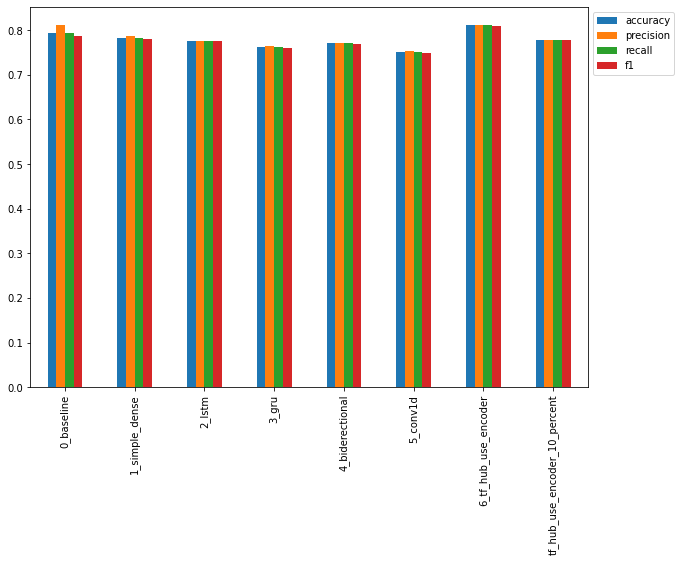

In [107]:
# Plot and compare all of the models results
all_models_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

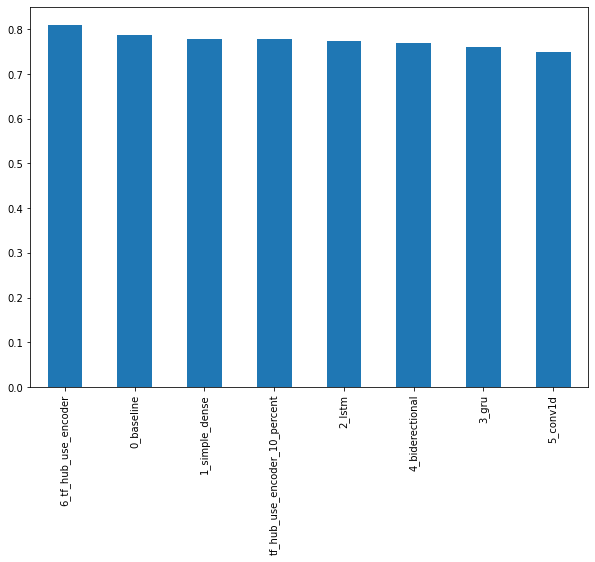

In [108]:
# Sort model results by f1-score
all_models_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7));

## Uploading our model training logs to Tensorboard.dev

In [109]:
!tensorboard dev upload --logdir model_logs/\
--name "My text learning experience"\
--description "Running multiple experiments ranging from simple to more complex while at the end using a pretrained model."

^C


## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5
2. The 'SaveModel' format (this is the default when using TensorFlow)


In [110]:
# Save TF Hub Sentence encoder model to HDF5 format
model_6.save('model_6.h5')

In [111]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model('model_6.h5',
                                            custom_objects={'KerasLayer': hub.KerasLayer})

In [112]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4310 - accuracy: 0.8110


[0.43095576763153076, 0.8110235929489136]

Now let's save to the SavedModel format

In [113]:
# Save TF hub sentence encoder model to savemodel
model_6.save('model_6_savedmodel_format')

INFO:tensorflow:Assets written to: model_6_savedmodel_format\assets


INFO:tensorflow:Assets written to: model_6_savedmodel_format\assets


In [114]:
loaded_model_6_savedmodel_format = tf.keras.models.load_model('model_6_savedmodel_format')

In [115]:
loaded_model_6_savedmodel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 8ms/step - loss: 0.4310 - accuracy: 0.8110


[0.4309559464454651, 0.8110235929489136]

## Visualize the data: Finding the most wrong examples

* If our best model still isnt' perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those with prediction probabilities closest to the opposite class)

FOr example if a sample should have a albel of 0 but our model predicts a predictions probability of 0.999 (really close to 1) and vice versa.

In [116]:
# Create DataFrame with validation sentences annd best performing model predictions
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred': model_6_preds,
                       'pred_prob': tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.186294
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.765971
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.980120
3,@camilacabello97 Internally and externally scr...,1,0.0,0.213376
4,Radiation emergency #preparedness starts with ...,1,1.0,0.774648


In [117]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong[:10] # False positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.905666
759,FedEx will no longer transport bioterror patho...,0,1.0,0.885966
628,@noah_anyname That's where the concentration c...,0,1.0,0.848454
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.846583
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.845831
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.837818
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.805167
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.796888
567,@RebeccaforReal accepts Wisconsin Emergency Re...,0,1.0,0.794091
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.778744


In [118]:
most_wrong.tail(10) # False negatives

,text,target,pred,pred_prob
681,'The way you move is like a full on rainstorm ...,1,0.0,0.061919
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.059734
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.057751
59,You can never escape me. Bullets don't harm me...,1,0.0,0.057690
221,going to redo my nails and watch behind the sc...,1,0.0,0.053290
233,I get to smoke my shit in peace,1,0.0,0.041048
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.040817
38,Why are you deluged with low self-image? Take ...,1,0.0,0.033779
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.031584
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.031505


In [119]:
# Check the false positives
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
  print(f'Textr:\n{text}\n')
  print('----\n')

Target: 0, Pred: 1.0, Prob: 0.9056664705276489
Textr:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8859659433364868
Textr:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.84845370054245
Textr:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8465834856033325
Textr:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1.0, Prob: 0.8458306193351746
Textr:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1.0, Prob: 0.8378177285194397
Textr:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1.0,

In [120]:
# False negatives 
# Check the false positives
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
  print(f'Textr:\n{text}\n')
  print('----\n')

Target: 1, Pred: 0.0, Prob: 0.06191898509860039
Textr:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0.0, Prob: 0.05973396450281143
Textr:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.0577506422996521
Textr:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.05768970772624016
Textr:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.053289882838726044
Textr:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04104791209101677
Textr:
I get to smoke my shit in peace

----

Target: 1, Pred: 0.0, Prob: 0.04081650823354721
Textr:

## Making predictions on the test dataset

In [121]:
test_data = test_df['text'].to_numpy()
len(test_data)

3263

In [122]:
model_6_test_pred_probs = model_6.predict(test_data)

In [123]:
model_6_test_preds = tf.squeeze(tf.round(model_6_test_pred_probs))
model_6_test_preds

<tf.Tensor: shape=(3263,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>

In [124]:
new_test_df = pd.DataFrame({'text': test_data,
                       'pred': model_6_test_preds,
                       'pred_prob': tf.squeeze(model_6_test_pred_probs)})
new_test_df.head()

,text,pred,pred_prob
0,Just happened a terrible car crash,1.0,0.611362
1,"Heard about #earthquake is different cities, s...",1.0,0.866598
2,"there is a forest fire at spot pond, geese are...",1.0,0.850625
3,Apocalypse lighting. #Spokane #wildfires,1.0,0.923053
4,Typhoon Soudelor kills 28 in China and Taiwan,1.0,0.955951


In [125]:
highest_probs = new_test_df.sort_values('pred_prob', ascending=False)
highest_probs.head()

,text,pred,pred_prob
548,#DNR\nRes. buildings shelled &amp; on fire in ...,1.0,0.993238
167,Arson suspect linked to 30 fires caught in Nor...,1.0,0.992787
199,Arson suspect linked to 30 fires caught in Nor...,1.0,0.992431
180,Arson suspect linked to 30 fires caught in Nor...,1.0,0.991989
3066,Dramatic Video Shows Plane Landing During Viol...,1.0,0.991772


In [126]:
# Predicting the highest probability cases and seeing whether they are correct based on inspection
for row in highest_probs[:10].itertuples():
  _, text, pred, pred_prob = row
  print(f'Pred: {pred}, Prob: {pred_prob}')
  print(f'Textr:\n{text}\n')
  print('----\n')

Pred: 1.0, Prob: 0.9932384490966797
Textr:
#DNR
Res. buildings shelled &amp; on fire in #Gorlovka tonight.
Civilian casualties Jan-July 2015:ÛÓ
164 killed (incl. 16 children)
501 wounded

----

Pred: 1.0, Prob: 0.9927870631217957
Textr:
Arson suspect linked to 30 fires caught in Northern California http://t.co/z8tlcAdKOw

----

Pred: 1.0, Prob: 0.9924310445785522
Textr:
Arson suspect linked to 30 fires caught in Northern California https://t.co/emsXyWp5s5

----

Pred: 1.0, Prob: 0.9919887185096741
Textr:
Arson suspect linked to 30 fires caught in Northern California http://t.co/HkFPyNb4PS

----

Pred: 1.0, Prob: 0.9917721152305603
Textr:
Dramatic Video Shows Plane Landing During Violent Storm http://t.co/YX8OdrrINr

----

Pred: 1.0, Prob: 0.9907854795455933
Textr:
Family evacuated after weather bomb http://t.co/2A4z8pmvVE

----

Pred: 1.0, Prob: 0.9898080229759216
Textr:
BBC News - India rail crash: Trains derail in Madhya Pradesh flash flood http://t.co/9UFemKfIiv

----

Pred: 1.0, P

In [127]:
for row in highest_probs[-10:].itertuples():
  _, text, pred, pred_prob = row
  print(f'Pred: {pred}, Prob: {pred_prob}')
  print(f'Textr:\n{text}\n')
  print('----\n')

Pred: 0.0, Prob: 0.01911037787795067
Textr:
@_Gags_ My Mommy will be devastated lol #NoMorePod

----

Pred: 0.0, Prob: 0.018122199922800064
Textr:
@skydragonforce ^^why i usually never try to express opinions for fear of the hate ._.

----

Pred: 0.0, Prob: 0.017525076866149902
Textr:
Do you feel deluged by unhappiness? Take the quiz: http://t.co/XUyfZkZ4k0 http://t.co/YupKvDIh8m

----

Pred: 0.0, Prob: 0.01654547080397606
Textr:
want a new season of The League and Sirens on Netflix.

----

Pred: 0.0, Prob: 0.015868056565523148
Textr:
Just want someone to smoke a blunt &amp; talk about life with ??

----

Pred: 0.0, Prob: 0.015499776229262352
Textr:
Check out the #new #ebook on #sale by #TimZak 'The Lizard Stuck in a #Blizzard' #rhyming #kidsbook on #Amazon http://t.co/kVZuxdL4ij

----

Pred: 0.0, Prob: 0.01530548557639122
Textr:
Would you consider yourself good at giving advice? ÛÓ I like to think I give good advice when I feel like its a s... http://t.co/lSMr4KVO6u

----

Pred: 0.0,

## My challenge .... predicting on Tweets from the wild

Go to twitter and pick a random tweet and check it out

In [128]:
tweet1 = "Hey there @TeamYouTube, I really want to talk to one of your team members (not a bot) in DMs about a bullying video that goes to my game, and I don't think it's going in the good category for community guidelines, please send a DM. Thank you!"
tweet2 = "I respect everyone and I do NOT want to atack/target anyone! So please don't send hate to anyone! Thank you for understanding about the models!😉 Next time, don't try to cancel the game or you'll get fired/banned.."

In [129]:
tweets = [tweet1, tweet2]

In [130]:
one_tweet_predict_prob = model_6.predict(tweets)
one_tweet_predict_prob

array([[0.06522079],
       [0.15820058]], dtype=float32)

In [131]:
two_tweet_pred = tf.squeeze(tf.round(one_tweet_predict_prob))
two_tweet_pred

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>

## The speed/score tradeoff

In [132]:
import time 
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [133]:
# Calculate TF hub sentence encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)

model_6_total_pred_time, model_6_time_per_pred

(0.19774539999997387, 0.00025950839895009695)

In [134]:
# Claculate our baseline model times per pred
baseline_total_time, baseline_time_per_sample = pred_timer(model_0, val_sentences)
baseline_total_time, baseline_time_per_sample

(0.00844560000001593, 1.108346456695004e-05)

Text(0, 0.5, 'F1-score')

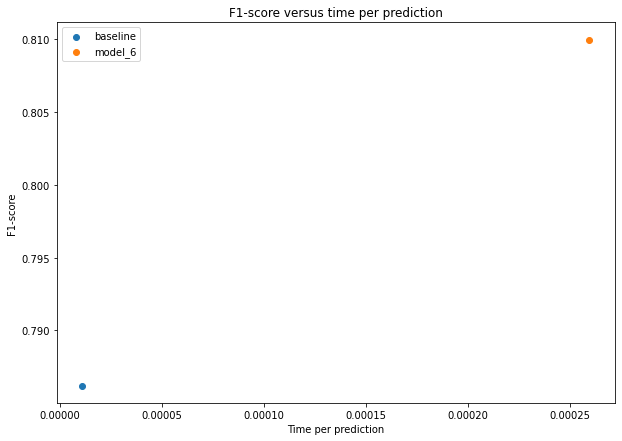

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_sample, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_results['f1'], label='model_6')
plt.legend()
plt.title('F1-score versus time per prediction')
plt.xlabel('Time per prediction')
plt.ylabel('F1-score')

# Extra tasks

## Normal extra tasks

### Creating model 1 with sequential instead

In [137]:
# Build model
model_1_sequential = tf.keras.Sequential([
                                          layers.Input(shape=(1,), dtype=tf.string),
                                          text_vectorizer,
                                          embedding,
                                          layers.GlobalAveragePooling1D(),
                                          layers.Dense(1, activation='sigmoid')
                                          
])

In [138]:
model_1_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [140]:
# Compile and train the model
model_1_sequential.compile(loss='binary_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

history_1_sequential = model_1_sequential.fit(train_sentences,
                                              train_labels,
                                              epochs=5,
                                              validation_data=(val_sentences, val_labels),
                                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'Extra_task_1')])

Saving TensorBoard log files to: model_logs/Extra_task_1/20220223-091642
Epoch 1/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4809 - accuracy: 0.8882 - val_loss: 0.4925 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 1s 3ms/step - loss: 0.2800 - accuracy: 0.9270 - val_loss: 0.4643 - val_accuracy: 0.7913
Epoch 3/5
215/215 [==============================] - 1s 3ms/step - loss: 0.2031 - accuracy: 0.9448 - val_loss: 0.4775 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 1s 3ms/step - loss: 0.1622 - accuracy: 0.9583 - val_loss: 0.5060 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 1s 3ms/step - loss: 0.1354 - accuracy: 0.9632 - val_loss: 0.5320 - val_accuracy: 0.7808


In [144]:
# Checking the result
model_1_sequential_pred_probs = model_1_sequential.predict(val_sentences)
model_1_sequential_preds = tf.squeeze(tf.round(model_1_sequential_pred_probs))
model_1_sequential_results = calculate_results(val_labels, model_1_sequential_preds)
print(f'Model_1 results: {model_1_results}\nModel_1_sequential results: {model_1_sequential_results}')

Model_1 results: {'accuracy': 78.21522309711287, 'precision': 0.7864332425219001, 'recall': 0.7821522309711286, 'f1': 0.7792361147360404}
Model_1_sequential results: {'accuracy': 78.08398950131233, 'precision': 0.7825889119713269, 'recall': 0.7808398950131233, 'f1': 0.7789136933207592}


### Making sequential of model 2

In [145]:
# Build model first (LSTM)
model_2_sequential = tf.keras.Sequential([
                                          layers.Input(shape=(1,), dtype=tf.string),
                                          text_vectorizer,
                                          embedding,
                                          layers.LSTM(64),
                                          layers.Dense(1, activation='sigmoid')
])

In [146]:
model_2_sequential.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [148]:
# Compile and train model
model_2_sequential.compile(loss='binary_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

history_2_sequential = model_2_sequential.fit(train_sentences,
                                              train_labels,
                                              epochs=5,
                                              validation_data=(val_sentences, val_labels),
                                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'Extra_task_2')])

Saving TensorBoard log files to: model_logs/Extra_task_2/20220223-092727
Epoch 1/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1119 - accuracy: 0.9609 - val_loss: 0.8423 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0507 - accuracy: 0.9777 - val_loss: 1.0478 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0453 - accuracy: 0.9790 - val_loss: 1.3606 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0398 - accuracy: 0.9804 - val_loss: 1.5049 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0393 - accuracy: 0.9806 - val_loss: 1.4882 - val_accuracy: 0.7703


In [152]:
def train_and_compile(model,
                      epochs,
                      val_data,
                      callback,
                      train_data=train_sentences,
                      train_label=train_labels):
  
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  
  history = model.fit(train_data,
                      train_labels,
                      epochs,
                      validation_data=val_data,
                      callbacks=callback)
  return history

In [153]:
test_history = train_and_compile(model_2_sequential,
                                 epochs=5,
                                 val_data=(val_sentences, val_labels),
                                 callback=create_tensorboard_callback(SAVE_DIR, 'nameofsomething'))

Saving TensorBoard log files to: model_logs/nameofsomething/20220223-093524
1371/1371 [==============================] - 8s 5ms/step - loss: 0.0677 - accuracy: 0.9707 - val_loss: 1.0540 - val_accuracy: 0.7664


### Model 5 as sequential

In [154]:
# Create the model
model_5_sequential = tf.keras.Sequential([
                                          layers.Input(shape=(1,), dtype=tf.string),
                                          text_vectorizer,
                                          embedding,
                                          layers.Conv1D(64, 5, activation='relu'),
                                          layers.GlobalMaxPool1D(),
                                          layers.Dense(1, activation='sigmoid')
])

In [156]:
model_5_sequential.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_6 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,321,089
Trainable params: 1,321,089
No

In [157]:
# Compile and  train the model
model_5_sequential.compile(loss='binary_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

history_5_sequential = model_5_sequential.fit(train_sentences,
                                              train_labels,
                                              epochs=5,
                                              validation_data=(val_sentences, val_labels),
                                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'Extra_task_3')])

Saving TensorBoard log files to: model_logs/Extra_task_3/20220223-094705
Epoch 1/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1055 - accuracy: 0.9645 - val_loss: 0.8873 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0666 - accuracy: 0.9756 - val_loss: 1.0134 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0562 - accuracy: 0.9784 - val_loss: 1.1532 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 1s 3ms/step - loss: 0.0510 - accuracy: 0.9778 - val_loss: 1.1674 - val_accuracy: 0.7546
Epoch 5/5
215/215 [==============================] - 1s 3ms/step - loss: 0.0475 - accuracy: 0.9781 - val_loss: 1.2123 - val_accuracy: 0.7572


### Retrain basemodel with 10%

In [161]:
model_0.fit(train_10_percent, train_labels_10_percent)
baseline_score_nr2 = model_0.score(val_sentences, val_labels)
print(f'Our baseline accuracy is: {baseline_score_nr2*100}%')

Our baseline accuracy is: 70.20997375328083%


### Tensorflow hub layer set it as true

In [167]:
#sentence_encoder_layer_2 = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
 #                                       input_shape=[],
  #                                      dtype=tf.string,
   #                                     trainable=True)

In [168]:
# Above I tried to run it but I have no memory, just need to set trainable=True
sentence_encoder_layer.trainable = True

In [169]:
model_8 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation='relu'),
                               layers.Dense(1, activation='sigmoid')
], name='Trainable_model')

In [170]:
model_8.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [171]:
model_8.summary()

Model: "Trainable_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_14 (Dense)            (None, 64)                32832     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


I stopped here because I don't have a good enough gpu to run it.

### Retrain on whole training set

In [175]:
all_train_data = train_df_shuffle['text'].to_numpy()
all_train_labels = train_df_shuffle['target'].to_numpy()
len(all_train_data), len(all_train_labels)

(7613, 7613)

In [177]:
model_9 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation='relu'),
                               layers.Dense(1, activation='sigmoid')
])

model_9.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history_9 = model_9.fit(all_train_data,
                        all_train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels))

Epoch 1/5
238/238 [==============================] - 3s 11ms/step - loss: 0.4996 - accuracy: 0.7847 - val_loss: 0.4362 - val_accuracy: 0.8110
Epoch 2/5
238/238 [==============================] - 2s 9ms/step - loss: 0.4150 - accuracy: 0.8174 - val_loss: 0.4159 - val_accuracy: 0.8241
Epoch 3/5
238/238 [==============================] - 2s 9ms/step - loss: 0.4021 - accuracy: 0.8228 - val_loss: 0.4014 - val_accuracy: 0.8268
Epoch 4/5
238/238 [==============================] - 2s 9ms/step - loss: 0.3941 - accuracy: 0.8269 - val_loss: 0.3965 - val_accuracy: 0.8294
Epoch 5/5
238/238 [==============================] - 2s 9ms/step - loss: 0.3872 - accuracy: 0.8317 - val_loss: 0.3840 - val_accuracy: 0.8399


In [178]:
model_9_pred_probs = model_9.predict(test_df['text'].to_numpy())

model_9_preds = tf.squeeze(tf.round(model_9_pred_probs))
model_9_preds = tf.cast(model_9_preds, dtype=tf.int32)

In [179]:
sub_csv = pd.read_csv('sample_submission.csv')
sub_csv.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [180]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [187]:
submissions = pd.DataFrame({'id': test_df['id'].values,
                            'target': model_9_preds.numpy()})
submissions

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [188]:
submissions.to_csv('submission.csv', index=False)

In [189]:
test_sentences = test_df['text'].to_numpy()


In [190]:
def get_preds(model, test_data):
  pred_probs = model.predict(test_data)
  preds = tf.squeeze(tf.round(pred_probs))
  preds = tf.cast(preds, dtype=tf.int32)

  return preds

In [192]:
model_9_pred = get_preds(model_9, test_sentences)
model_2_pred = get_preds(model_1, test_sentences)
model_5_pred = get_preds(model_5, test_sentences)

In [193]:
preds_df = pd.DataFrame({'USE': model_9_pred,
                         'LSTM': model_2_pred,
                         'Conv1D': model_5_pred})
preds_df

,USE,LSTM,Conv1D
0,1,1,1
1,1,0,0
2,1,1,1
3,1,0,1
4,1,1,1
...,...,...,...
3258,1,1,1
3259,1,1,1
3260,1,1,1
3261,1,0,1


In [194]:
preds_df['ensamble'] = preds_df.mode(axis=1)
preds_df

,USE,LSTM,Conv1D,ensamble
0,1,1,1,1
1,1,0,0,0
2,1,1,1,1
3,1,0,1,1
4,1,1,1,1
...,...,...,...,...
3258,1,1,1,1
3259,1,1,1,1
3260,1,1,1,1
3261,1,0,1,1
